**Remaining To-Do**
- save 6x intermediate results (separate base & drought scenario files for all 3 case studies)
- figure generation as a separate area of code
- note that it might have been cleaner to concatenate all of these various scenario results, and process as a single data frame...

# Overview
**DayCent regional simulation results post-processing**

This Jupyter Notebook is designed to facilitate post-processing and analysis of sets of raw DayCent results from a regional scale simulation. For more information, contact author [John Field](https://johnlfield.weebly.com/) at <john.L.field@gmail.com>

## DayCent background

DayCent is a process-based model that simulates agro-ecosystem net primary production, soil organic matter dynamics, and nitrogen (M) cycling and trace gas emissions. DayCent is a daily-timestep version of the older CENTURY model. Both models were created and are currently maintained at the Colorado State University [Natural Resource Ecology Laboratory](https://www.nrel.colostate.edu/) (CSU-NREL), and source code is available upon request.  DayCent model homepage:  [https://www2.nrel.colostate.edu/projects/daycent/](https://www2.nrel.colostate.edu/projects/daycent/)

![Alt text](DayCent.png)

## Regional workflow

The primary spatial data inputs to DayCent are:
* soil texture as a function of depth
* historic daily weather (Tmin, Tmax, precip)

Our DayCent spatial modeling workflow is based on a national-scale GIS database of current land use ([NLCD](https://www.mrlc.gov/national-land-cover-database-nlcd-2016)), soil ([SSURGO](https://www.nrcs.usda.gov/wps/portal/nrcs/detail/soils/survey/?cid=nrcs142p2_053627)), and weather ([NARR](https://www.ncdc.noaa.gov/data-access/model-data/model-datasets/north-american-regional-reanalysis-narr)) data layers housed at CSU-NREL. The python-based workflow consists of a collection of scripts that perform the following:
1. Selection of area to be simulated, specified based on current land cover and/or land biophysical factors (i.e., soil texutre, slope, land capability class rating, etc.)
2. Determination of individual unique DayCent model runs (i.e., **"strata"**) necessary to cover the heterogenity of soils and climate across the simulation area
3. Parallel execution of simulations on the CSU-NREL computing cluster
4. Results analysis and mapping (this routine)

# Code & data imports

## Load python modules

In [2]:
import constants as con
from IPython.display import Image, display
import json
import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import os
import pandas as pd
import plotly.express as px
import sys
from urllib.request import urlopen

## Load runtable

Individual DayCent strata are specified via a .csv format "runtable" file, which contains the following information:
* unique identifier (strata_no)
* ID for DayCent spin-up archive (runno)
* SSURGO soil map unit ID (mukey_int)
* NARR climate grid ID (gridx & gridy)
* county FIPS code (fips)
* DayCent-format schedule file to simulate (sch_file)
* latitude of the county centroid, used to set perennial grass phenology (latitude)
* for simulations on abandoned agricultural land, year of peak ag land extent (peak_year)
* land area represented by that strata (tot_ha)
The code below loads the relevant runtable to a Pandas dataframe.

In [2]:
runtable = "eastern_US_runtable_incl81.csv"
run_df = pd.read_csv(runtable, skiprows=[1])   # skip SQL datatype row
run_df

,strata_no,runno,mukey_int,gridx,gridy,fips,sch_file,latitude,peak_year,tot_ha
0,1,8942,328058,89,234,1001,idle_switchgrass75.sch,32.534931,1950,165.751842
1,2,17925,328059,89,234,1001,idle_switchgrass75.sch,32.534931,1950,17.960497
2,3,27012,328060,89,234,1001,idle_switchgrass75.sch,32.534931,1950,235.329205
3,4,36132,328061,89,234,1001,idle_switchgrass75.sch,32.534931,1950,2.221341
4,5,45302,328062,89,234,1001,idle_switchgrass75.sch,32.534931,1950,63.330603
...,...,...,...,...,...,...,...,...,...,...
446628,493330,2544675,426469,129,215,55141,idle_switchgrass75.sch,44.455314,1955,11.353384
446629,493331,2544675,426469,129,215,55141,idle_switchgrass75.sch,44.455314,1960,23.341606
446630,493332,2553283,426471,129,215,55141,idle_switchgrass75.sch,44.455314,1955,1.186769
446631,493333,2578533,426498,129,215,55141,idle_switchgrass75.sch,44.455314,1955,4.934340


## Load DayCent results

Raw DayCent model output is spread across two files:
* .lis files contain information related to per-area biomass harvest and soil carbon
* year_summary.out contains per-area trace gas emissions

Reading these DayCent results data directly from the NREL network via Pulse Secure is ideal for avoiding clutter on my local machine. However, that is only practical for smaller datasets; multi-GB data takes hours to load. I had also tried to develop code in this notebook to sub-set the large DayCent raw results files on the NREL network (see code_scraps.py), to minimize the volume of data being read over the network or downloaded locally. However, it seems that reading network data over Pulse Secure is the bottle-neck (not necessarily loading it into a large Pandas DataFrame), so running that sub-setting routine from this notebook on my own machine was similarly slow.

I eventually found it quicker & more flexible to download the big raw data files locally via a shell Secure Copy command (with Pulse Secure DISabled), and process via a more normal linear workflow. The scp step takes approximately 2 min per GB. After that, reading the local data to memory is reasonable (~2 min), and merging & filtering steps are quick enough (usually ~1 min each) that there is no need to change my workflow (designed more for code length & clarity than memory management). Here's an example shell Secure Copy command, for reference:
```console
scp jlf@trailridge.nrel.colostate.edu:/data/paustian/AFRI/simulations/results/2019-11-01,00.37__eastern_US_runtable_incl81__90__drought_sensitivity/year_summary.out /Users/johnfield/Desktop/2019-11-01,00.37__eastern_US_runtable_incl81__90__drought_sensitivity_year_summary.out
 ```

In [3]:
# specify simulation names for both baseline & drought tolerance results
base_sims = '2019-09-16,13.26__eastern_US_runtable_incl81__79__CBI_baseline'
drought_sims = '2019-11-01,00.37__eastern_US_runtable_incl81__90__drought_sensitivity'

In [4]:
# # inspect head of raw data files over Pulse Secure 

# results_path = '/Volumes/wcnr-network/Research/Paustian/AFRI/simulations/results/'
# base_fpath = os.path.join(results_path, base_sims, 'X.lis')
# drought_fpath = os.path.join(results_path, drought_sims, 'X.lis')

# # base python equivalent to a basd 'head' command
# with open(base_fpath) as myfile:
#     head = [next(myfile) for x in range(5)]
# print(head)
# print()

# with open(drought_fpath) as myfile:
#     head = [next(myfile) for x in range(5)]
# print(head)

First, we load and concatenate the .lis output for the relevant switchgrass variety scenarios. 

In [5]:
%%time

results_path = '/Users/johnfield/Desktop/'

# .lis data import, skipping SQL datatype rows
base_lis_fpath = os.path.join(results_path, base_sims+'_X.lis')
base_lis_df = pd.read_csv(base_lis_fpath, skiprows=[1])   # 3.7 GB 
base_lis_df['variety'] = 'base'

drought_lis_fpath = os.path.join(results_path, drought_sims+'_X.lis')
drought_lis_df = pd.read_csv(drought_lis_fpath, skiprows=[1])   # 3.7 GB 
drought_lis_df['variety'] = 'drought_tol'

# concatenate scenario results
lis_df = pd.concat([base_lis_df, drought_lis_df], axis=0)

# drop dummy data, including placeholder 'crop' & 'land_type' columns, and blank rows at the end
# of .lis output for each simulation (time=2069)
lis_df.drop(columns=['crop', 'land_type'], inplace=True)
lis_df = lis_df[lis_df['time'] != 2069]

CPU times: user 1min 52s, sys: 1min 28s, total: 3min 21s
Wall time: 5min 28s


Then, we do the same for the year_summary.out results.

In [6]:
%%time

# year_summary.out data import, skipping SQL datatype rows
base_ys_fpath = os.path.join(results_path, base_sims+'_year_summary.out')
base_ys_df = pd.read_csv(base_ys_fpath, skiprows=[1])   # 3.7 GB 
base_ys_df['variety'] = 'base'

drought_ys_fpath = os.path.join(results_path, drought_sims+'_year_summary.out')
drought_ys_df = pd.read_csv(drought_ys_fpath, skiprows=[1])   # 3.7 GB 
drought_ys_df['variety'] = 'drought_tol'

# concatenate scenario results
ys_df = pd.concat([base_ys_df, drought_ys_df], axis=0)

# drop dummy placeholder 'crop' & 'land_type' columns
ys_df.drop(columns=['crop', 'land_type'], inplace=True)

CPU times: user 1min 13s, sys: 44.2 s, total: 1min 58s
Wall time: 2min 45s


Repeat the same sequence for the drought-tolerant variety scenario

In [7]:
# check no. of strata in merged results for consistency w/ runtable

print("Unique .lis strata count:", lis_df.strata_no.nunique())
print("Unique year_summary.out strata count:", ys_df.strata_no.nunique())

Unique .lis strata count: 446633
Unique year_summary.out strata count: 446633


In [8]:
# note that these abandoned land simulations begin in different years in different counties

lis_df.time.value_counts().sort_index()

1975    452218
1976    452218
1977    452218
1978    500600
1979    500600
         ...  
2064    893266
2065    893266
2066    893266
2067    893266
2068    893266
Name: time, Length: 94, dtype: int64

# Analysis

## Merge .lis & .out data

In [9]:
%%time

# merge .lis & year_summary.out DataFrames
df = pd.merge(lis_df, ys_df, on=['strata_no', 'variety', 'time'])

# drop unneeded DayCent outputs
df = df[['strata_no', 'variety', 'time', 'crmvst',
        'd_somsc', 'N2Oflux', 'strmac(2)', 'volpac', 'NOflux', 'CH4']]
df

CPU times: user 56.6 s, sys: 2min 1s, total: 2min 58s
Wall time: 6min 11s


,strata_no,variety,time,crmvst,d_somsc,N2Oflux,strmac(2),volpac,NOflux,CH4
0,1,base,1975,0.000,0.000,0.071433,0.000,0.000,0.054203,0.221034
1,1,base,1976,0.000,24.276,0.013492,1.791,1.053,0.030303,0.247949
2,1,base,1977,0.000,38.979,0.020945,0.395,0.587,0.032218,0.246919
3,1,base,1978,0.000,46.176,0.022181,0.201,0.627,0.041216,0.216468
4,1,base,1979,0.000,70.583,0.020329,0.374,0.693,0.039546,0.214066
...,...,...,...,...,...,...,...,...,...,...
77693987,493298,drought_tol,2064,721.696,-10.893,0.135830,2.803,0.871,0.167733,0.099974
77693988,493298,drought_tol,2065,668.319,-1.855,0.148403,2.006,0.816,0.231958,0.102632
77693989,493298,drought_tol,2066,539.703,-10.087,0.127958,5.434,0.680,0.132562,0.104190
77693990,493298,drought_tol,2067,712.912,-2.034,0.143936,5.415,0.856,0.160256,0.093030


## Unit conversions

Most DayCent outputs are in units of grams of carbon per meter squared (g C m-2), though some of the nitrogen flux results are reported on a per-hectare basis instead. The code below performs basic unit converions to express the results in more familiar units of kg or Mg per hectare. It is implemented as a loop, so that the same code can be used to process both the 'base' and 'drought' cases. 

In [10]:
%%time

# drop all past period results
df = df[df['time'] >= 2020]

# unit conversions
df['yield_Mg_ha'] = ((df['crmvst'] * con.g_m2_to_Mg_ha) / con.C_concentration)
df['dSOC_MgC_ha'] = (df['d_somsc'] * con.g_m2_to_Mg_ha)
df['dN2ON_kgN_ha'] = (df['N2Oflux'] * con.g_m2_to_kg_ha)
df['iN2ON_kgN_ha'] = ((0.0075 * df['strmac(2)'] + 0.01 * df['volpac'] +
                           0.01 * df['NOflux']) * con.g_m2_to_kg_ha)
df['kgCH4_ox_ha'] = (df['CH4'] * con.g_m2_to_kg_ha)
df['ghg_MgCO2e_ha'] = (df['dSOC_MgC_ha'] * con.C_to_CO2 * -1.0) + \
                           ((df['dN2ON_kgN_ha'] + df['iN2ON_kgN_ha']) *
                            con.kg_ha_to_Mg_ha * con.N_to_N2O * con.N2O_GWP100_AR5) + \
                    (df['kgCH4_ox_ha'] * con.kg_ha_to_Mg_ha * con.CH4_GWP100_AR5 * -1.0)
df['volit_kgN_ha'] = df['volpac'] * con.g_m2_to_kg_ha
df['leached_kgN_ha'] = df['strmac(2)'] * con.g_m2_to_kg_ha

# drop the original columns with non-standard unit data
df.drop(columns=['crmvst', 'd_somsc', 'N2Oflux',
                 'strmac(2)', 'volpac', 'NOflux', 'CH4'], inplace=True)
df

/Users/johnfield/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/Users/johnfield/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/johnfield/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

CPU times: user 15.7 s, sys: 43.1 s, total: 58.8 s
Wall time: 1min 41s


/Users/johnfield/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:4102: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,strata_no,variety,time,yield_Mg_ha,dSOC_MgC_ha,dN2ON_kgN_ha,iN2ON_kgN_ha,kgCH4_ox_ha,ghg_MgCO2e_ha,volit_kgN_ha,leached_kgN_ha
45,1,base,2020,20.125467,-0.52026,1.12733,0.390229,2.16955,2.477341,8.98,38.48
46,1,base,2021,21.189867,-0.09696,1.40849,0.307026,1.98605,1.013902,11.44,23.79
47,1,base,2022,24.418444,-0.24485,1.12298,0.422058,2.37433,1.473930,13.07,37.35
48,1,base,2023,21.391156,0.08657,1.36280,0.493622,2.03076,0.398851,11.68,48.32
49,1,base,2024,23.656467,-0.20300,1.38067,0.363542,2.00467,1.413864,12.66,29.63
...,...,...,...,...,...,...,...,...,...,...,...
77693987,493298,drought_tol,2064,16.037689,-0.10893,1.35830,0.314098,0.99974,1.067425,8.71,28.03
77693988,493298,drought_tol,2065,14.851533,-0.01855,1.48403,0.255246,1.02632,0.763367,8.16,20.06
77693989,493298,drought_tol,2066,11.993400,-0.10087,1.27958,0.488806,1.04190,1.076676,6.80,54.34
77693990,493298,drought_tol,2067,15.842489,-0.02034,1.43936,0.507751,0.93030,0.859145,8.56,54.15


## Area-weighted county aggregation

In [11]:
%%time

# re-associate FIPS codes and land areas with strata results
area_df = pd.merge(run_df[['strata_no', 'fips', 'tot_ha']], df, on='strata_no')
area_df

CPU times: user 8.27 s, sys: 11.8 s, total: 20 s
Wall time: 33.9 s


,strata_no,fips,tot_ha,variety,time,yield_Mg_ha,dSOC_MgC_ha,dN2ON_kgN_ha,iN2ON_kgN_ha,kgCH4_ox_ha,ghg_MgCO2e_ha,volit_kgN_ha,leached_kgN_ha
0,1,1001,165.751842,base,2020,20.125467,-0.52026,1.12733,0.390229,2.16955,2.477341,8.98,38.48
1,1,1001,165.751842,base,2021,21.189867,-0.09696,1.40849,0.307026,1.98605,1.013902,11.44,23.79
2,1,1001,165.751842,base,2022,24.418444,-0.24485,1.12298,0.422058,2.37433,1.473930,13.07,37.35
3,1,1001,165.751842,base,2023,21.391156,0.08657,1.36280,0.493622,2.03076,0.398851,11.68,48.32
4,1,1001,165.751842,base,2024,23.656467,-0.20300,1.38067,0.363542,2.00467,1.413864,12.66,29.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43770029,493334,55141,0.163107,drought_tol,2064,16.474667,-0.17073,1.73664,0.424582,1.58910,1.480881,8.88,42.19
43770030,493334,55141,0.163107,drought_tol,2065,17.493444,-0.15014,1.87389,0.482289,1.39219,1.492120,9.39,49.46
43770031,493334,55141,0.163107,drought_tol,2066,16.772578,-0.15382,0.96667,0.651324,2.07677,1.179097,9.01,72.97
43770032,493334,55141,0.163107,drought_tol,2067,17.278444,0.16615,2.11015,0.291472,1.73187,0.342624,9.33,23.98


First, we combine the total production and impacts associated with each strata in each year by multiplying the per-ha results with the area represented by each strata:

In [12]:
%%time

# calculate area totals & drop obsolete data
area_tot_df = area_df.copy(deep=False)

columns = ['yield_Mg', 'dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN',
           'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']
for column in columns:
    area_tot_df[column] = area_tot_df[column+'_ha'] * area_tot_df['tot_ha']
    area_tot_df.drop(columns=[column+'_ha'], inplace=True)

area_tot_df

CPU times: user 40 s, sys: 1min 12s, total: 1min 52s
Wall time: 2min 48s


,strata_no,fips,tot_ha,variety,time,yield_Mg_ha,dSOC_MgC_ha,dN2ON_kgN_ha,iN2ON_kgN_ha,kgCH4_ox_ha,ghg_MgCO2e_ha,volit_kgN_ha,leached_kgN_ha
0,1,1001,165.751842,base,2020,20.125467,-0.52026,1.12733,0.390229,2.16955,2.477341,8.98,38.48
1,1,1001,165.751842,base,2021,21.189867,-0.09696,1.40849,0.307026,1.98605,1.013902,11.44,23.79
2,1,1001,165.751842,base,2022,24.418444,-0.24485,1.12298,0.422058,2.37433,1.473930,13.07,37.35
3,1,1001,165.751842,base,2023,21.391156,0.08657,1.36280,0.493622,2.03076,0.398851,11.68,48.32
4,1,1001,165.751842,base,2024,23.656467,-0.20300,1.38067,0.363542,2.00467,1.413864,12.66,29.63
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43770029,493334,55141,0.163107,drought_tol,2064,16.474667,-0.17073,1.73664,0.424582,1.58910,1.480881,8.88,42.19
43770030,493334,55141,0.163107,drought_tol,2065,17.493444,-0.15014,1.87389,0.482289,1.39219,1.492120,9.39,49.46
43770031,493334,55141,0.163107,drought_tol,2066,16.772578,-0.15382,0.96667,0.651324,2.07677,1.179097,9.01,72.97
43770032,493334,55141,0.163107,drought_tol,2067,17.278444,0.16615,2.11015,0.291472,1.73187,0.342624,9.33,23.98


Then, we aggregate these results to the county scale, and divide by the total area simulated for each county to calculate area-weighted results:

In [13]:
%%time

# group results to annual county scale
retain_data = ['fips', 'variety', 'time', 'tot_ha', 'yield_Mg',
               'dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN', 
               'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']

annual_df = area_tot_df[retain_data].groupby(['fips', 'variety', 'time']).sum()
annual_df = annual_df.reset_index()
    
# divide by area & drop obsolete data
for column in ['dSOC_MgC', 'dN2ON_kgN', 'iN2ON_kgN',
               'kgCH4_ox', 'ghg_MgCO2e', 'volit_kgN', 'leached_kgN']:
    annual_df[column+'_ha'] = annual_df[column] / annual_df['tot_ha']
    annual_df.drop(columns=[column], inplace=True)

# calculate per-area yields and total county production in mega-tonne (Mt) units
annual_df['yield_Mg_ha'] = annual_df['yield_Mg'] / annual_df['tot_ha']
annual_df['prod_Mt'] = annual_df['yield_Mg'] * 1.0e-6
annual_df.drop(columns=['yield_Mg'], inplace=True)

# calculate fraction of annual N application lost via leaching + volatilization
annual_df['leach_volit_frac'] = (annual_df['volit_kgN_ha'] + 
                                          annual_df['leached_kgN_ha']) / 75.0
    
annual_df

CPU times: user 8.71 s, sys: 12 s, total: 20.7 s
Wall time: 35.8 s


,fips,variety,time,tot_ha,dSOC_MgC_ha,dN2ON_kgN_ha,iN2ON_kgN_ha,kgCH4_ox_ha,ghg_MgCO2e_ha,volit_kgN_ha,leached_kgN_ha,yield_Mg_ha,prod_Mt,leach_volit_frac
0,1001,base,2020,31214.547584,-0.623765,1.012279,0.398199,1.775289,2.823046,8.415007,40.130671,19.322204,0.603134,0.647276
1,1001,base,2021,31214.547584,-0.129921,1.406390,0.302483,1.511085,1.145207,11.207136,22.978972,20.504069,0.640025,0.455815
2,1001,base,2022,31214.547584,-0.350858,1.024119,0.469430,1.979914,1.851956,12.851256,43.727718,23.969685,0.748203,0.754386
3,1001,base,2023,31214.547584,-0.004440,1.318424,0.483908,1.615370,0.721426,10.335541,48.373541,18.560574,0.579360,0.782788
4,1001,base,2024,31214.547584,-0.313962,1.318589,0.440436,1.561780,1.839004,11.990331,40.420055,22.141354,0.691132,0.698805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
245485,55141,drought_tol,2064,11585.669969,-0.098473,1.106488,0.495297,1.633220,0.981974,8.976065,52.267747,16.699695,0.193477,0.816584
245486,55141,drought_tol,2065,11585.669969,0.081260,2.023721,0.296872,1.362933,0.630261,8.794493,25.690650,16.152115,0.187133,0.459802
245487,55141,drought_tol,2066,11585.669969,-0.022573,2.227383,0.448443,1.256080,1.161600,8.494607,46.220396,15.644459,0.181252,0.729533
245488,55141,drought_tol,2067,11585.669969,-0.040204,1.654972,0.248132,1.506254,0.897479,9.579254,18.646591,17.827137,0.206539,0.376345


## Time-averaging

Finally, we aggregate over simulation years to get time-averaged county-scale results:

In [14]:
county_df = annual_df.groupby(['fips', 'variety']).mean()
county_df.reset_index(inplace=True)

# add leading zeros to FIPS codes (otherwise this causes mapping failure)
county_df['fips'] = county_df['fips'].apply(lambda x: '{0:0>5}'.format(x))

# Base case maps

In [14]:
# import shapefile of county boundaries
shapeurl = 'https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json'
with urlopen(shapeurl) as response:
    counties = json.load(response)

# define lat/long/zoom factors appropriate for visualizing the Corn Belt
map_width = 500   # pixels
aspect_ratio = 0.64
map_zoom = 2.8
cen_lat = 38.5
cen_lon = -87.5
prod_lim = 1.0
prod_colors = 'deep'

# define standard plot limits across crops
yield_lims = [0, 25.0]  # (Mg ha-1 y-1)
area_lims = [0, 1.0e5]  # (ha)
prod_lims = [0, 1.0]  # (Mt y-1)

# In interactive mapping mode, live Plotly maps maps are displayed. If false, 
# static maps are saved in PNG & PDF formats, and static PNG map is displayed
interactive_map = False


def mapping(df, data_column, colorscale, label, kwargs={}):
    my_map = px.choropleth_mapbox(df, geojson=counties, locations='fips',
                                  color=data_column,
                                  color_continuous_scale=colorscale,
                                  mapbox_style='open-street-map',
                                  zoom=map_zoom,
                                  center={"lat": cen_lat, "lon": cen_lon},
                                  labels={data_column: label},
                                  **kwargs)
    my_map.update_layout(width=map_width, height=map_width*aspect_ratio, 
                         margin={"r":0,"t":0,"l":0,"b":0})
    if interactive_map:
        my_map.show()
    else:
        my_map.write_image(data_column + ".pdf")
        my_map.write_image(data_column + ".png")
        display(Image(filename=data_column + ".png")) 

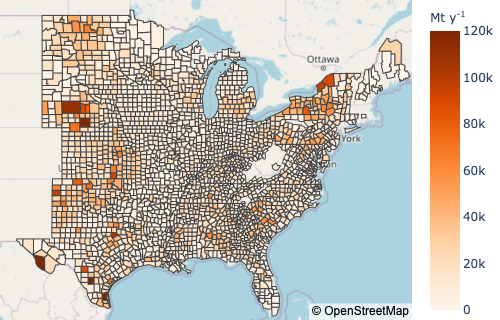

In [16]:
mapping(county_df[county_df.variety == 'base'],
        'tot_ha', 'Oranges', 'Mt y<sup>-1</sup>',
       kwargs={"range_color": [0, 120e3]})

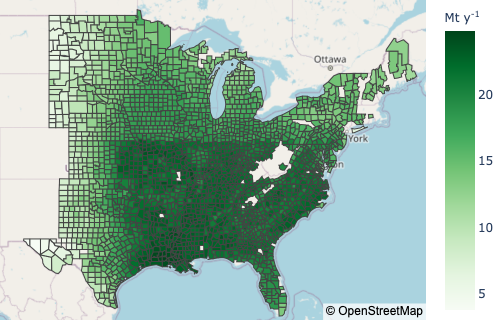

In [17]:
mapping(county_df[county_df.variety == 'base'],
        'yield_Mg_ha', 'Greens', 'Mt y<sup>-1</sup>')

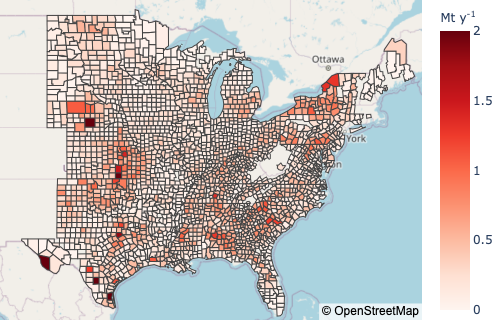

In [18]:
mapping(county_df[county_df.variety == 'base'],
        'prod_Mt', 'Reds', 'Mt y<sup>-1</sup>',
        kwargs={"range_color": [0.0, 2.0]})

# Case study data

Below we subset the full annual dataset (annual_df) to show three multi-county case study feedstock-sheds in IA, PA & TN, in order to look at yield variability (both farm-scale and inter-annual). These initial county lists are derived from Haley's analysis of the 2016 Billion Ton Study (looking specifically at combined switchgrass and Miscanthus production potential in the year 2040 at a biomass price of $80/ton). I took her list of high-production-density counties, and selected 4–5 contiguous ones for each case study.

![Alt text](Haley_case_studies.png)

## Determine FIPS lists

In [11]:
# define dictionary of case study counties by name

county_sets = {"IA": ['Ringgold', 'Taylor', 'Union', 'Adams', 'Adair'],
               "TN": ['Maury', 'Marshall', 'Giles', 'Bedford', 'Moore'],
               "PA": ['Adams', 'Cumberland', 'Franklin', 'York']}
# "KS": ['Cheyenne', 'Rawlins', 'Thomas', 'Sherman']

In [12]:
# get fips codes for case study counties

all_fips_df = pd.read_csv('All_FIPS.csv')
all_fips_df.rename(columns={'FIPS': 'fips'}, inplace=True)

fips_sets = {}
for cs in county_sets:
    fips_list = []
    for county in county_sets[cs]:
        fips = all_fips_df.loc[(all_fips_df.County == county) & (all_fips_df.ST == cs), 'fips'].item()
        fips_list.append(fips)
    fips_sets[cs] = fips_list

    fips_sets

/Users/johnfield/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.


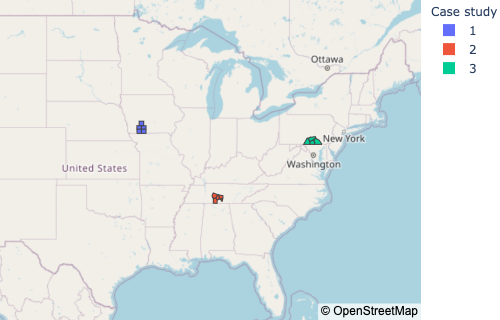

In [15]:
# verify case study FIPS by mapping

map_df = pd.DataFrame(columns=('cs', 'fips', 'map_value'))
for i, cs in enumerate(fips_sets):
    for fips in fips_sets[cs]:
        map_df.loc[len(map_df)] = [cs, fips, i+1]

mapping(map_df, 'map_value', '', 'Case study')

## Subset the annual data

In [ ]:
# extract timestamp for original simulations to use in case study file names
base_ts = base_sims.split('_')[0]
drought_ts = drought_sims.split('_')[0]

for CS in fips_sets:
    
    # new DataFrame containing a single cycle of historic weather for the case study counties
    cs_df = area_df[(area_df.fips.isin(fips_sets[CS]) & area_df.time.between(2020, 2050))]

    # convert area yield rates to total county production in mega-tonne (Mt) units
    cs_df['prod_Mt'] = cs_df['yield_Mg_ha'] * cs_df['tot_ha'] * 1.0e-6
    
    # merge county names & ST abbreviation for readability
    cs_df = pd.merge(all_fips_df[['fips', 'County', 'ST']], cs_df, on='fips')

    cs_df.to_csv('{}_case_study_{}_{}.csv'.format(CS, base_ts, drought_ts), index=False)
    
# display a representative subsetted DataFrame
cs_df

# Case study visualization

In [17]:
##### Set up case study visualization to run one-at-a-time based on specified case study?
cs = 'IA'
cs_file_suffix = '_case_study_2019-09-16,13.26_2019-11-01,00.37.csv'
cs_df = pd.read_csv(cs+cs_file_suffix)
cs_df

,fips,County,ST,strata_no,tot_ha,variety,time,yield_Mg_ha,dSOC_MgC_ha,dN2ON_kgN_ha,iN2ON_kgN_ha,kgCH4_ox_ha,ghg_MgCO2e_ha,volit_kgN_ha,leached_kgN_ha,prod_Mt
0,19001,Adair,IA,101557,0.067418,base,2020,15.561867,-0.03163,0.95217,0.121205,2.03375,0.505842,7.45,6.03000,0.000001
1,19001,Adair,IA,101557,0.067418,base,2021,15.434044,0.25020,1.54524,0.098655,1.94954,-0.286910,8.34,0.74495,0.000001
2,19001,Adair,IA,101557,0.067418,base,2022,18.505622,0.22990,1.83829,0.109133,1.86111,-0.083681,9.87,0.00000,0.000001
3,19001,Adair,IA,101557,0.067418,base,2023,17.100422,0.29296,1.88108,0.105113,2.04243,-0.303672,9.26,0.00000,0.000001
4,19001,Adair,IA,101557,0.067418,base,2024,17.224511,0.09219,2.83118,0.109160,1.51727,0.843918,9.33,0.00000,0.000001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54555,19175,Union,IA,126251,12.730414,drought_tol,2046,18.292133,-0.10999,1.73464,0.587853,1.91381,1.316378,9.74,65.15000,0.000233
54556,19175,Union,IA,126251,12.730414,drought_tol,2047,16.036600,0.00077,1.40180,0.311098,2.15751,0.649922,8.69,28.46000,0.000204
54557,19175,Union,IA,126251,12.730414,drought_tol,2048,13.354533,0.12454,2.94280,0.216636,2.03223,0.802186,7.40,16.60000,0.000170
54558,19175,Union,IA,126251,12.730414,drought_tol,2049,11.342000,-0.06572,2.51542,0.393601,2.10772,1.392937,6.38,41.58000,0.000144


## Plot variability

In [18]:
# new DataFrame grouping case study data by county & year
cs_time_df = cs_df[['County', 'time', 'prod_Mt']].groupby(['County', 'time']).sum()
cs_time_df

prod_Mt
County time          
Adair  2020  0.193013
       2021  0.184310
       2022  0.204603
       2023  0.231442
       2024  0.230531
...               ...
Union  2046  0.300263
       2047  0.275662
       2048  0.280598
       2049  0.222171
       2050  0.297502

[155 rows x 1 columns]

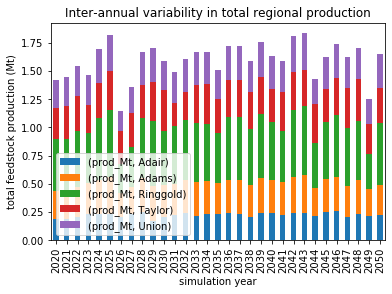

In [19]:
# plot annual total production across all counties
cs_time_df.unstack(level=0).plot(kind='bar', stacked=True)
plt.title("Inter-annual variability in total regional production")
plt.xlabel("simulation year")
plt.ylabel("total feedstock production (Mt)")
plt.legend(loc=3)

In [20]:
# determine lowest & highest-yielding years

extrema_df = cs_time_df.reset_index()
del extrema_df['County']
extrema_df = extrema_df.groupby(['time']).sum()

extrema_df.sort_values(by=['prod_Mt'], inplace=True)
year_sort = list(extrema_df.index) 

# extrema_years = (year_sort[0], year_sort[len(year_sort)//2], year_sort[-1])
extrema_years = (year_sort[0], year_sort[-1])
print(extrema_years)

(2026, 2043)


No handles with labels found to put in legend.


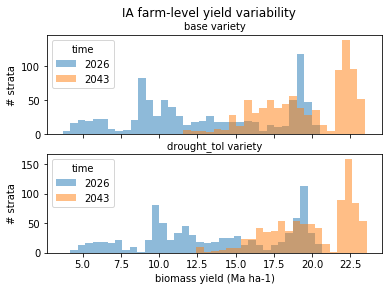

In [21]:
##### At this point, need to loop through 'base' and 'drought_tol' scenarios separately

fig, ax = plt.subplots(2, 1, sharex=True)
fig.suptitle('{} farm-level yield variability'.format(cs))
plt.xlabel("biomass yield (Ma ha-1)")
plt.legend(loc=3)

varieties = ['base', 'drought_tol']
for i, variety in enumerate(varieties):
    
    hist_df = cs_df[(cs_df.time.isin(extrema_years)) &
                    (cs_df.variety == variety)][['strata_no', 'time', 'yield_Mg_ha']]
    
    hist_df = hist_df.pivot(index='strata_no', columns='time', values='yield_Mg_ha')
    
    hist_df.plot.hist(bins=40, alpha=0.5, ax=ax[i])
    ax[i].set_title('{} variety'.format(variety), fontsize=10)
    ax[i].set_ylabel("# strata", fontsize=10)

## DayCent–BTS2016 comparison

In [ ]:
# import BTS data
bts_df = pd.read_excel("Bioenergy KDF Billion Ton Report County Level Data_2040-JLF.xlsx", sheet_name='SG & M_PA')
bts_df.rename(columns={'Prod':'BTS_prod_Mg'}, inplace=True)

# compute DayCent total county production
county_df['daycent_prod_Mg'] = county_df['yield_Mg_ha'] * county_df['tot_ha']

# merge data and create scatterplot
comp_df = pd.merge(bts_df[['Fips', 'BTS_prod_Mg']],
                   county_df[['fips', 'daycent_prod_Mg']],
                   left_on='Fips', right_on='fips')
comp_df.plot.scatter(x='BTS_prod_Mg', y='daycent_prod_Mg')
# plt.plot([0, 1.2e6], [0, 1.2e6], color='k')
plt.xlabel("BTS2016 yield (Mg y-1)")
plt.ylabel("DayCent yield (Mg y-1)")
plt.title("Comparing county-level estimates from BTS2016 and DayCent")

# Climate analysis
Here's some initial exploratory code to parse a DayCent-format weather file and analyze inter-annual variability in growing-season temperatures and precipitation.

In [ ]:
weather_file1 = "NARR_89_234.wth"
weather_df1 = pd.read_csv(weather_file1, sep='\t', usecols=range(1, 7),
                         names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
weather_file2 = "NARR_89_231.wth"
weather_df2 = pd.read_csv(weather_file2, sep='\t', usecols=range(1, 7),
                         names=['DayOfMonth','Month', "Year", "DayOfYear", 'Tmax_C', 'Tmin_C', "Precip_cm"])
weather_df2

In [ ]:
wth_df = pd.merge(weather_df1, weather_df2, on=['Month', 'Year', 'DayOfYear'], suffixes=['_234', '_231'])
seasonal_wth_df = wth_df[wth_df['Month'].isin([5, 6, 7, 8, 9])]
seasonal_wth_df['Tavg_C_231'] = (seasonal_wth_df['Tmin_C_231'] + seasonal_wth_df['Tmax_C_231']) / 2.0
seasonal_wth_df['Tavg_C_234'] = (seasonal_wth_df['Tmin_C_234'] + seasonal_wth_df['Tmax_C_234']) / 2.0
annunal_wth_df = seasonal_wth_df.groupby('Year').agg({'Tmax_C_231': 'mean',
                                                      'Tavg_C_231': 'mean',
                                                      'Precip_cm_231': 'sum',
                                                      'Tmax_C_234': 'mean',
                                                      'Tavg_C_234': 'mean',
                                                      'Precip_cm_234': 'sum'})
annunal_wth_df['Precip_diff_cm'] = annunal_wth_df['Precip_cm_231'] - annunal_wth_df['Precip_cm_234']
annunal_wth_df.head()

In [ ]:
fig = plt.figure()
spec = gridspec.GridSpec(ncols=1, nrows=2, height_ratios=[1, 2])
fig.suptitle("Difference between two weather grid centroids, 100km apart")

ax0 = fig.add_subplot(spec[0])
ax0.bar(annunal_wth_df.index, annunal_wth_df.Precip_diff_cm)
plt.setp(ax0.get_xticklabels(), visible=False)
plt.ylabel("Difference (cm)")

ax1 = fig.add_subplot(spec[1], sharex=ax0)
ax1.plot(annunal_wth_df.Precip_cm_231)
ax1.plot(annunal_wth_df.Precip_cm_234)
plt.xlabel("Year")
plt.ylabel("May–Sept. total precip (cm)")

In [ ]:
plt.scatter(annunal_wth_df.Tavg_C_231, annunal_wth_df.Precip_cm_231)
plt.title("Inter-annual variability in growing season weather")
plt.xlabel("May–Sept. average air temperature (C)")
plt.ylabel("May–Sept. total precipitation (cm)")